# Современные методы распознавания и синтеза речи
## Практическое задание 2: Распознавание речи

В данном задании вы разработаете систему распознавания речи на примере предсказания цифр. Вам будет дана обучающая выборка с произнесеннми цифрами (0-9), а также тестовая выборка аудиофайлов, для которых надо будет предсказать фразы.

**Замечание:** Полный алгоритм описан в книге [Speech and Language Processing](https://1drv.ms/u/s!Ap7BENKQpVbHhxtoTnIqLvI-jo8a), в 9-й главе. При возникновении вопросов, рекомендуем обратиться к этому учебнику.

In [1]:
import warnings
import os
from IPython.display import Audio, display
import numpy as np
import librosa
from librosa.display import specshow
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft, dct, ifft
from sklearn.model_selection import train_test_split
from scipy.stats import norm
warnings.simplefilter('error')
%matplotlib inline

В выданном архиве, помимо Jupter Notebook, находятся следующие файлы:
* cmudict-0.7b.txt – [фонетический словарь CMU (для ознакомления)](https://github.com/Alexir/CMUdict/blob/master/cmudict-0.7b)
* cmu_digits.txt — фонетический словарь цифр
* data/ — аудиофайлы с цифрами. Каждый подкаталог — отдельный класс. В конечных файлах содержится произношение цифр на английском языке.

In [2]:
DATA_PATH = './data/'
SAMPLE_RATE = 16000


In [3]:
# Загружаем данные и делаем train-validation split 
train = dict()
test = dict()
for path in sorted(os.listdir(DATA_PATH)):
    full_path = os.path.join(DATA_PATH, path)
    if os.path.isdir(full_path):
        class_name = path.upper()
        class_files = [os.path.join(full_path, f) for f in sorted(os.listdir(full_path))]
        waves = [librosa.load(file, sr=SAMPLE_RATE)[0] for file in class_files]
        np.random.seed(777) # Не забываем про воспроизводимость
        train_waves, test_waves = train_test_split(waves)
        train[class_name] = train_waves
        test[class_name] = test_waves

In [4]:
display(Audio('data/eight/004ae714_nohash_0.wav'))

In [5]:
# Загружаем словарь фонем (нужен для бонусной части)
phonemes_dictionary = {x[0]: x[1:] for x in [x.split() for x in open('cmu_digits.txt')]}
phonemes_dictionary

Exception ignored in: <_io.FileIO name='cmu_digits.txt' mode='rb' closefd=True>


{'EIGHT': ['EY1', 'T'],
 'FIVE': ['F', 'AY1', 'V'],
 'FOUR': ['F', 'AO1', 'R'],
 'NINE': ['N', 'AY1', 'N'],
 'ONE': ['W', 'AH1', 'N'],
 'SEVEN': ['S', 'EH1', 'V', 'AH0', 'N'],
 'SIX': ['S', 'IH1', 'K', 'S'],
 'THREE': ['TH', 'R', 'IY1'],
 'TWO': ['T', 'UW1'],
 'ZERO': ['Z', 'IY1', 'R', 'OW0']}

## Часть 1. Извлечение MFCC признаков (опционально, +5 баллов)
Простейшие алгоритмы распознвания речи работают с построенными вручную признаками звуковых сигналов. Обучение на сырых данных, как правило, приводит к низкому качеству распознвания при использовании HMM моделей. В этой части задания мы реализуем функционал для извлечения таких признаков — [MFCC](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) (Mel frequency cepstrum coefficients).

Построение MFCC коэффициентов происходит в несколько этапов. На первом этапе сигнал разбивается на кадры (frame) при помощи окон. В качестве окна для построения MFCC коэффициентов используется окно Хемминга: 

$$w[n] = \begin{cases}0.54 - 0.46\cos(\frac{2\pi n}{L}) & 0 \le n < L \\ 0 & \textrm{иначе}\end{cases}$$

Параметр $L$ выбирается таким образом, чтобы длина окна соответствовала 25ms. Кадры вычисляются со сдвигом в 10ms, то есть первый кадр будет соответствовать временному интервалу $[0, 25]$, второй — $[10, 35]$ и так далее. Итоговый сигнал получается поэлементным домножением исходного сигнала на сдвинутое окно.

Второй шаг в алгоритме вычисления MFCC — усиление высоких частот (preemphasis). Такой эффект можно добиться, применив фильтр $y[n] = x[n] - \alpha x[n-1]$, где $\alpha \in [0.9, 1]$. Чтобы убедиться, что этот фильтр усиливает высокие частоты, посмотрите на $\mathcal{Z}$-transform этого фильтра.

От каждого полученного окна вычисляется дискретное преобразование Фурье (DFT). Далее сигнал переводится в [mel](https://en.wikipedia.org/wiki/Mel_scale) шкалу, чтобы получить представление, линейное по восприятию. Сопоставление mel и частот (в Гц): $mel(f) = 1127\ln(1+\frac{f}{700})$. Таким образом, частоты ниже 1000Hz преобразуются линейно, а более высокие частоты — логарифмически сжимаются. Перевод осуществляется следующим образом: шкала частот $[0, f_{\max}]$ переводится в mel шкалу: $[0, mel_{\max}]$. Далее mel шкала разбивается на некоторое число равных интервалов. Каждой граничной точке интервала ставится в соответствие частота $f(mel) = (exp(mel/1127)-1)/700$. В результате получаем последовательность частот $f[k]$. Наконец, получаем mel коэффициенты, вычисляя логарифм суммарной энергии в треугольных окнах $f[k-1], f[k], f[k+1]$: $H_k[m] = 
\begin{cases}
0 & m < f[k-1] \\ 
\frac{m-f[k-1]}{f[k]-f[k-1]} & f[k-1] \le m \le f[k] \\
\frac{f[k+1]-m}{f[k+1]-f[k]} & f[k] \le m \le f[k+1] \\
0 & m > f[k+1]\end{cases}$

Mel коэффициенты $i$-ого окна: $S_i[k] = \ln(\sum_{m=0}^{L-1}(|X_i[m]|^2H_k[m])$.

Mel признаки уже можно использовать для обучения моделей распознавания речи. Тем не менее, значительно лучшие результаты получаются при использовании спектра Mel коэффициентов, кепструм. Кепструм — спектр логарифма спектра. Он позволяет отедлить компоненты, создаваемые голосовыми связками и речевым трактом. Формально, для получения кепструма надо взять дискретное косинусное преобразование от mel коэффициентов. Из итоговых коэффициентов обычно оставляют около 12 первых компонент. Дополнительно к этим компонентам добавляют суммарную энергию фрейма. Также добавляют разность признаков соседних фреймов и разность разностей (вторая производная) фреймов. Суммарно получаем 39 коэффициентов на каждый фрейм.

Более детальное описание есть в учебнике и [тут](https://habrahabr.ru/post/140828/).

In [6]:

def getDelta(mfcc):
    return np.vstack((mfcc[1,:]/2, (mfcc[2:,:]-mfcc[:-2,:])/2, -mfcc[-2,:]))



def extract_own_mfcc(sound, sampling_rate, shift=32., L=128., mel_coefs=120, mfcc_coefs=12, alpha=0.9, eps=1e-9):
    signal_length = len(sound)
    emphasized_signal = np.append(sound[0], sound[1:] - 0.9 * sound[:-1]) ### Авторы метода делали преэмфазис до окна.
    frame_length, frame_step = L/1000 * sampling_rate, shift/1000*sampling_rate  # Теперь перевод размера окна и смещения из мс в индексы
    frame_length = int(round(frame_length)) #  Округляем на всякий случай, т.к. деление!!! 
    frame_step = int(round(frame_step)) #
    num_frames = int(np.ceil(float(np.abs(signal_length)) / frame_step))  # Получаем количество фреймов
    pad_signal_length = num_frames * frame_step + frame_length # УЗнали, сколько фреймов мы покрываем
    z = np.zeros((pad_signal_length - signal_length)) # И насколько наш последний фрейм вылезает и делаем столько нулей
    pad_signal = np.append(emphasized_signal, z) # нули добавляем в конец сигнала.
    
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    ## Вот тут важный момент, нашли индексы для каждого фрейма. К примеру, первый фрейм имеет длину 128мс. Или 128мс*16эл/млсек=2047
    ## и получаются индексы каждого фрейма: 0-2047, потом смещаемся на 32*16=512, 512 - 2559 и.т.д. Так получаем индексы каждого фрейма
    frames = pad_signal[indices.astype(np.int32, copy=False)] # И вот тут уже получаем массив из 28 фреймов!!! 
    
    frames *= np.hamming(frame_length) # Домножаем на окно Хэмминга. Оно есть готовое в нумпае
    NFFT = 512 # Для экономии времени авторы использовали Short Time FT с параметром 512. Так работает действительно быстрее
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Ищем спектр фреймов
    #print(mag_frames.shape)
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2)) #Жнергия фреймов
    low_freq_mel = 0 # Самая низкая частота. Иногда ставят 1000Гц, но оставим с нулем
    high_freq_mel = (2595 * np.log10(1 + (sampling_rate / 2) / 700))  # Переводим сразу все частоты в мелы
    
    mel_points = np.linspace(low_freq_mel, high_freq_mel, mel_coefs + 2)  # Бьем мел-шкалу на равные интервалы, на 120 по умолч.
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # И потом переводим из мелов обратно в частоту
    bin = np.floor((NFFT + 1) * hz_points / sampling_rate) 

    fbank = np.zeros((mel_coefs, int(np.floor(NFFT / 2 + 1)))) #Теперь конструируем мел_фильтры, "ГОРКИ"
    for m in range(1, mel_coefs + 1):
        f_m_minus = int(bin[m - 1])   # Слева низ от горки
        f_m = int(bin[m])             # вершинка горки
        f_m_plus = int(bin[m + 1])    # справа низ горки

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1]) ## формируем банк мел-фильтров. Сформировано по формуле
        for k in range(f_m, f_m_plus):                                 ## Hkm из описания в шапке
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T) # А теперь без циклов и прочего находим сразу все мелы по банкам
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Так как дальше берем логарифм, а есть нулевые элементы
    filter_banks = 20 * np.log10(filter_banks)  # то добавляем сюда эпсилон и потом берем логарифм
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : mfcc_coefs+1] # косинусное преобразование. Авторы отрезали 12 с первого.
    ## мы поступим так же
    energies = pow_frames.sum(axis=1) # добавили энергии
    mfcc = np.hstack((mfcc, energies.reshape((num_frames,1)))) 
    mfcc_delta = getDelta(mfcc)# Нашли разности
    mfcc_delta2 = getDelta(mfcc_delta)
    mfcc = np.hstack((mfcc, mfcc_delta, mfcc_delta2))
    return mfcc

Данная процедура выделения признаков может быть настроена более тщательно. Например, можно подбирать значение параметра Short Time Fourier Transform или даже вовсе использовать другой тип FT. Также можно изменять тип дискретного косинусного преобразования и его нормировку. Также возможны эксперименты с размером окна и смещением.

In [7]:
#### Старый метод, юзал для тестов. 
#def extract_mfcc(sound, sampling_rate, shift=32., L=128., mel_coefs=120, mfcc_coefs=12, alpha=0.9, eps=1e-9):
#    mfcc = librosa.feature.mfcc(sound, sampling_rate, n_mfcc= 12) #Забираю фичи с либросы
    #print(librosa.feature.powerSpectrum(sound))
#    frame_len = 128*16
#    shift_len = 32*16
#    energies = []
#    for i in range(len(mfcc[0])): # Считаю энергию каждого окна
#        end = i*shift_len+frame_len if i*shift_len+frame_len <len(sound) else len(sound) 
#        energies.append((sound[i*shift_len:end]**2).sum())
#    energies = np.array(energies).reshape((1,len(mfcc[0]))) #Добавляю энергию к окнам#

#    mfcc = np.vstack((mfcc, np.array(energies))) # Добавление в сам массив
#    mfcc_delta = librosa.feature.delta(mfcc) # Беру дельты первого порядка
#    mfcc_delta2 = librosa.feature.delta(mfcc, order = 2) #Вторые дельты
#    mfcc = np.transpose(np.vstack((mfcc, mfcc_delta, mfcc_delta2))) # Финальный массив из фичей, энергий и их дельт
#    return mfcc

#a = extract_mfcc(train['EIGHT'][0], SAMPLE_RATE)
b = extract_own_mfcc(train['EIGHT'][0], SAMPLE_RATE)
print(b.shape)

(32, 39)


In [8]:
# Извлекаем MFCC для всех точек

train_mfccs = dict()
test_mfccs = dict()
for class_name in train:
    mfccs = []
    for sound in train[class_name]:
        mfcc = extract_own_mfcc(sound, SAMPLE_RATE)
        mfccs.append(mfcc)
    train_mfccs[class_name] = mfccs
    
    mfccs = []
    for sound in test[class_name]:
        mfcc = extract_own_mfcc(sound, SAMPLE_RATE)
        mfccs.append(mfcc)
    test_mfccs[class_name] = mfccs
del(train)
del(test)

Если вы решили не реализовывать MFCC признаки, используйте готовую функцию из `librosa`.

# Часть 2. Обучение ASR модели
Теперь обучим 10 HMM в unsupervised режиме. Каждая будет отвечать за отдельное слово из словаря и оценивать $p(sound | word)$

Если вы застряли с пониманием формул, рекомендуем обратиться к следующей литературе: [Hidden Markov Models](https://web.stanford.edu/~jurafsky/slp3/9.pdf), [HMM cheat sheet](http://www.bcl.hamilton.ie/~barak/misc/hmm.pdf), [A tutorial on HMM](http://www.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/tutorial%20on%20hmm%20and%20applications.pdf).

Для инициализации $p(o|i) = \mathcal{N}(\mu_i, \Sigma_i)$ будем использовать глобальную оценку среднего и дисперсии по MFCC признакам: $\mu_i = \mu$, $\Sigma_i = \Sigma$. Также будем рассматривать только диагональные матрицы ковариации.

Альтернативно можно реализовать ASR так, как это было рассказано на лекции (см. [Speech and Language Processing](https://1drv.ms/u/s!Ap7BENKQpVbHhxtoTnIqLvI-jo8a), в 9-й): +10 баллов

# ВНИМАНИЕ!

Я действительно честно и искренне хотел реализовать данную модель. Но, к сожалению, после огромного числа попыток и нескольких дней увлеченного дебага моделей всё же ничего не вышло. Некоторую, довольно малую часть моих попыток реализации можно найти внизу ноутбука в части "Кладбище моих GaussianHMM". На этом кладбище есть живой охранник в виде рабочей дискретной HMM. Подробнее с историей реализации можно ознакомиться на кладбище. 

Я действительно старался. Ошибку найти действительно сложно, т.к. все параметры, такие, как self.A, self.m, self.S остаются у последних версий в норме, обучение идет без вылетов, в несколько эпох, но точность модели всё равно оставляет желать лучшего. Подробнее ниже в конце ноутбука

Но всё же, чтобы приобрести навыки по распознаванию речи я решил попробовать пообучать готовые GaussianHMM из модуля hmmlearn. Так я смогу понять эффективность этого подхода и применять знания, полученные в курсе на практике. 

Надеюсь, что мои опыты с RandomForest, CNN  и конечно же с пусть и готовой Марковской моделью из модуля HMMLearn, а также рабочий дискретный HMM смогут покрыть неудачу, которую я потерпел при реализации своего GaussianHMM. Спасибо за понимание. Я обязательно разберусь с GaussianHMM, но позже, так как у моей программы магистратуры уже начинаются экзамены! 

С уважением и надеждой на понимание, студент группы М-110, Булыгин М.В.

# Часть 3. Оценка качества модели
Для предсказания слова применим формулу Байеса:
$arg\max p(w|o) = arg\max \frac{p(o|w)p(w)}{p(o)} = arg\max p(o|w)p(w)$. Вероятность $p(w)$ можно оценить по обучающей выборке, а $p(o|w)$ мы уже научились оценивать при помощи HMM. Оцените точность обученной модели по тестовой выборке. 

In [9]:
pW = np.array(list(map(lambda x:len(train_mfccs[x]), train_mfccs.keys())))# TODO
print(pW/pW.sum())

[0.09979965 0.10061357 0.10092662 0.0994866  0.10061357 0.09936138
 0.09923616 0.09967443 0.09967443 0.10061357]


В случае использования реализации GaussianHMM из hmmlearn выяснилось, что домножение на эти вероятности не дает никакого эффекта в случае обученного GaussianHMM. Действительно, можно заметить, что данные вероятности почти равны. 

Для того, чтобы не загромождать код в дальнейшем, домножение на них опущено

#### Бонус (+5 баллов)
Как зависит качество от числа эпох? От числа состояний сети?

Сначала подготовим тестовую выборку в вид, удобный для параллельного оценивания. 

In [10]:
accum = []
accum_Y = []
counter = 0
for i in test_mfccs.keys():
    accum.append((test_mfccs[i])) # Всё сваливаем в один тестовый набор
    accum_Y.append([counter]*len(test_mfccs[i])) # Все семплы по одному ключу словаря имеют один верный ответ!!! 
    counter+=1
testX = np.concatenate(accum)
testY = np.concatenate(accum_Y)
print(len(testY)) ## Здесь зафиксированы все верные метки классов
print(len(testX)) ## Тут все тестовые наблюдение


5328
5328


# Код в ячейке ниже не выполнять
## Он работает из отдельного файла worker.py .
Сделано так, чтобы обеспечить возможность параллельной работы в Jupyter под Windows. Нам необходимо обучать по десять моделей (для каждой цифры). Параллельная реализация позволит проводить более интересные опыты. Код приведен для того, чтобы не смотреть в отдельный файл и полностью совпадает с ним

In [ ]:
from hmmlearn.hmm import GaussianHMM # Готовая реализация GaussianHMM. Если запустить здесь, будет конфликт далее. На вин8 точно
import numpy as np
def myFunc(args):
    trainset, testset, states, iters = args # Передаем аргументом тренировочный сет, тестовый (сразу от всех), число итераций обучения и число состояний
    lengths = list(map(lambda x: x.shape[0], trainset)) # Особенность работы модуля. Именно с этим ленгтх нужно передать трейнсет
    model = GaussianHMM(n_components=states, covariance_type="diag", n_iter=iters, algorithm="viterbi", tol = 1e-10) # тол - порог остановки для логарифма правдоподобия
    train = np.concatenate(trainset) # Подготовка аргументов к передаче в фиттинг
    model.fit(train, lengths) # Обучение
    scoring = []
    for sample in testset: 
    	scoring.append(model.score(sample)) # Скор возвращает lоg правдоподобия, который как раз нам нужен! 
    return scoring


In [16]:
from multiprocessing import Pool
import worker

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

## Исследование зависимости точности модели от числа состояний

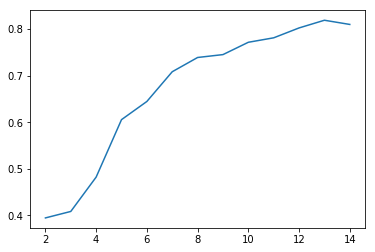

Wall time: 9min 21s


In [17]:
%%time
accFromStates = []
for n_states in range(2, 15):  ## Оцениваем влияние количества состояний на точность
    myArgs = []
    for i in test_mfccs.keys():
        myArgs.append((test_mfccs[i], testX, n_states, 10)) ## 10 -количество состояний. Достаточно для высокой точности
    
    if __name__ ==  '__main__': 
        num_processors = 3
        p=Pool(processes = num_processors) ## Параллельный мап на 3 процессах
        output = p.map(worker.myFunc,myArgs)
        output = np.array(output)
        acc = []
        for i in range(output.shape[1]):
            if np.argmax(output[:,i]) == testY[i]:    ## Зачем-то вручную сделал accuracy_score для аргмаксов 
                acc.append(1)
            else:
                acc.append(0)
        
    accFromStates.append(np.array(acc).sum()/len(acc))

plt.plot(range(2,15), accFromStates)
plt.show()

По оси X представлено количество состояний, по оси Y откладывается точность модели в долях от единицы

In [18]:
print(test_mfccs['ONE'][0].shape)
print("Максимальная точность ", np.array(accFromStates).max(), " достигнута при числе состояний ", np.argmax(np.array(accFromStates))+2)

(32, 39)
Максимальная точность  0.8188813813813813  достигнута при числе состояний  13


## Вывод: 
Марковские модели неплохо справились с задачей. С ростом числа состояний растет и точность, однако после n_states = 13 точность не увеличивается. А иногда даже уменьшается. Переобучение

In [191]:
print(test_mfccs['ONE'][0].shape)
print("Максимальная точность ", np.array(accFromStates).max(), " достигнута при числе состояний ", np.argmax(np.array(accFromStates))+2)

(32, 39)
Максимальная точность  0.729166666667  достигнута при числе состояний  14


В данной ячейке был сохранен результат после применения модели к MFCC, полученным с значением параметра SFT = 1024. Точность модели снизилась. 

In [180]:
print(test_mfccs['ONE'][0].shape)
print("Максимальная точность ", np.array(accFromStates).max(), " достигнута при числе состояний ", np.argmax(np.array(accFromStates))+2)

(28, 13)
Максимальная точность  0.685247747748  достигнута при числе состояний  14


В данной ячейке было использовано 12 MFCC и энергии. Без разностей. Результат оказался значительно хуже. Таким образом, данный эксперимент показывает, что действительн имеет смысл добавлять разности

## Исследование зависимости точности от числа эпох обучения

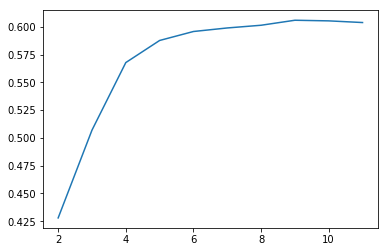

Максимальная точность  0.6058558558558559  достигнута при числе эпох  9
Wall time: 4min 17s


In [14]:
%%time
accFromEpochs = []
for n_epochs in range(2, 12):
    myArgs = []
    for i in test_mfccs.keys():
        myArgs.append((test_mfccs[i], testX, 5, n_epochs))
    
    if __name__ ==  '__main__': 
        num_processors = 3
        p=Pool(processes = num_processors)
        output = p.map(worker.myFunc,myArgs)
        output = np.array(output)
        acc = []
        for i in range(output.shape[1]):
            if np.argmax(output[:,i]) == testY[i]:
                acc.append(1)
            else:
                acc.append(0)
        
    accFromEpochs.append(np.array(acc).sum()/len(acc))

plt.plot(range(2,12), accFromEpochs)
plt.show()
print("Максимальная точность ", np.array(accFromEpochs).max(), " достигнута при числе эпох ", np.argmax(np.array(accFromEpochs))+2)

In [15]:
%%time
accFromEpochs = []
for n_epochs in range(2, 12):
    myArgs = []
    for i in test_mfccs.keys():
        myArgs.append((test_mfccs[i], testX, 10, n_epochs))
    
    if __name__ ==  '__main__': 
        num_processors = 3
        p=Pool(processes = num_processors)
        output = p.map(worker.myFunc,myArgs)
        output = np.array(output)
        acc = []
        for i in range(output.shape[1]):
            if np.argmax(output[:,i]) == testY[i]:
                acc.append(1)
            else:
                acc.append(0)
        
    accFromEpochs.append(np.array(acc).sum()/len(acc))

plt.plot(range(2,12), accFromEpochs)
plt.show()
print("Максимальная точность ", np.array(accFromEpochs).max(), " достигнута при числе эпох ", np.argmax(np.array(accFromEpochs))+2)

Максимальная точность  0.7802177177177178  достигнута при числе эпох  10
Wall time: 6min 17s


## Вывод
С ростом количества эпох увеличивается и точность моделей. Причем это утверждение верно как для моделей с сравнительно небольшим числом состояний, так и для моделей с бОльшим количеством. Однако стоит заметить, что значительный прирост точности наблюдался при увеличеении числа эпох до 6. После прирост точности был небольшим, а при числе эпох больше 10 и вовсе замечено снижение точности.

## О модели в целом

В целом модель показала высокую точность свыше 80%. К недостаткам такого метода распознавания команд можно отнести то, что необходимо держать сразу 10 моделей. Они занимают много памяти, а также требуют больше времени для расчетов. Последнюю проблему частично можно компенсировать параллельной обработкой данных. 

Возможно повышение точности засчет использования GMMHMM, однако в этих моделях еще больше коэффициентов для расчета, поэтому проблемы памяти и времени вычислений усугубятся. 

Лучшим вариантом может быть использование модели, привязанной к фонемам. В таком случае будет использоваться всего одна модель. Для установления точности такого типа моделей необходимы доп. эксперименты

# RandomForest and CNN

Попробуем использовать другие методы для распознавания команд. К примеру, попробуем использовать случайные леса и сверточные нейронные сети.

Данные методы в классическом виде требуют семплов одинаковой размерности. В нашем же случае число признаков одинаково, но вот длина признакового описания каждого семпла разная. Для компенсации этого явления будем брать по 10 MFCC для каждого сэмпла через равные промежутки. 

Учитывая среднюю длину данных в 20-30 MFCC мы сокращаем количество признаков в 2-3 раза.

Подготовим данные:

In [11]:
def cut(list_for_cut, count=10):  ### Функция из Nx39 делает 10x39 , забирая наблюдения через равномерные промежутки
    retList = []
    
    for sample in list_for_cut:
        new_sample = np.zeros((count, 39))
        t = 0
        inds = []
        for i in range(0,count):
            inds.append(float(sample.shape[0])/count*i)
        
        for j in inds:
            #print(j)
            #print(t)
            new_sample[t,:]=sample[int(np.floor(j)),:]
            t+=1
        retList.append(new_sample)
    return retList


#print(inds)

accum = []
accum_Y = []
counter = 0
for i in test_mfccs.keys():                 ## Собираем обработанные данные о всех цифрах в один обучающий сет
    cutted = cut(test_mfccs[i])
    accum.append(cutted) 
    accum_Y.append([counter]*(len(test_mfccs[i]))) # Все семплы по одному ключу словаря имеют один верный ответ!!! 
    counter+=1
    
    
testX = np.concatenate(accum)
testY = np.concatenate(accum_Y)
print(len(testY)) ## Здесь зафиксированы все верные метки классов
print(len(testX)) ## Тут все тестовые наблюдение


accum = []
accum_Y = []
counter = 0
for i in train_mfccs.keys():            ## Аналогично поступаем с тренировочным
    cutted = cut(train_mfccs[i])
    accum.append(cutted)
    accum_Y.append([counter]*len(train_mfccs[i])) # Все семплы по одному ключу словаря имеют один верный ответ!!! 
    counter+=1

trainX = np.concatenate(accum)
trainY = np.concatenate(accum_Y)

#print(trainX[0])

print(len(trainY)) ## Здесь зафиксированы все верные метки классов

print(len(trainX)) ## Тут все тестовые наблюдение

5328
5328
15972
15972


Сверточная нейронная сеть может работать и с двумерными данными. А вот для случайных лесов удобнее брать одномерные!

Подготовим тренировочные и тестовые данные для случайного леса

In [12]:
RFXTest = [] 
RFXTrain = []  # Делаем признаки одномерными для случайного леса!!!

for sample in trainX:
    RFXTrain.append(sample.ravel())

for sample in testX:
    RFXTest.append(sample.ravel())
print(len(RFXTrain))
print(len(RFXTest))

15972
5328


## RandomForest

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Обучим случайные леса с различным числом деревье и глубиной!

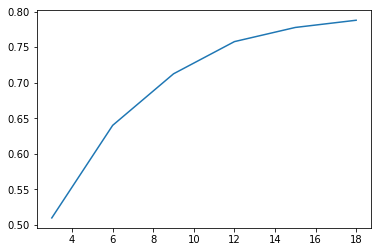

Максимальная точность  0.7877252252252253 достигнута для глубины  18
Wall time: 21min 16s


In [15]:
%%time
accs = []
for depth in range(3, 19, 3):
    myClassifier = RandomForestClassifier(n_estimators = 1000, max_depth = depth)
    myClassifier.fit(RFXTrain, trainY)

    y_test = myClassifier.predict(RFXTest)
    accs.append(accuracy_score(testY, y_test))
    
plt.plot(range(3, 19, 3), accs)
plt.show()
print("Максимальная точность ", np.array(accs).max() , "достигнута для глубины ", range(3, 19, 3)[np.argmax(np.array(accs))])

## Вывод

С увеличением глубины также растет и точность. Глубина деревье достигла 18, а эффекта переобучения еще не наблюдается. На последних итерациях точность изменялась несильно, а вот вычислительная сложность для большого количества деревьев большой глубины возросла. Опыт был прекращен при максимальной глубине деревьев 18. 

Точность одного RandomForest в контексте нашего испытания сравнима с точностью, полученной при применении GaussianHMM

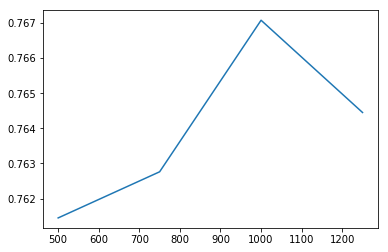

Максимальная точность  0.7670795795795796 достигнута для числа деревьев:  1000
Wall time: 15min 9s


In [16]:
%%time

accs = []
for n in range(500, 1500, 250):
    myClassifier = RandomForestClassifier(n_estimators = n, max_depth = 13)
    myClassifier.fit(RFXTrain, trainY)
    y_test = myClassifier.predict(RFXTest)
    accs.append(accuracy_score(testY, y_test))

plt.plot(range(500, 1500, 250), accs)
plt.show()
print("Максимальная точность ", np.array(accs).max() , "достигнута для числа деревьев: ", range(500, 1500, 250)[np.argmax(np.array(accs))])

## Вывод

Точность модели растет с увеличением числа деревьев до тысячи. После начинает наблюдаться падение точности! 

## CNN 

Ну и на закуску попробуем нейронную сеть, которая мне помогла в распознавании изображений. Немного адаптируем ее к модели и попробуем показать результат! Сеть реализована для TensorFlow 1.1.0 и Keras 2.0.8 . В случае запуска на более новых версиях, Sequential импортировать из keras, а kernel_size = 3 заменить на (3,3)

In [37]:
import keras
print(keras.__version__)
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten


2.0.8


Данная нейронная сеть состоит из входного слоя, размер которого совпадает с нашими подготовленными семплами: 1x10x39, двух сверточных слоев с 32 фильтрами и размерами ядра 3x3, одного MaxPooling слоя с размером ядра 2x2 (4 числа сводятся в одно). Слоя Dropout с параметром P=0.25 , который "выключает" четверть нейронов каждый раз, а также двух полносвязных слоев размерности 128 (функция активации ReLU) и 10 - выходного слоя с функцией активации softmax. Выходной слой показывает вероятности, с которыми вход относится к каждому из 10 выходных классов. Модель скомпилирована с оптимизатором Adam и функцией ошибки - категориальной кросс-энтропии. 

Похожая модель была использована мной для распознавания цифр MNIST. Также похожую модель использовали для распознавания типов активности по данным с мобильных акселерометров

In [60]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

model = Sequential()
model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape=(1,10,39), data_format='channels_first'))
model.add(Activation("relu"))
model.add(Conv2D(32, (3, 3),  padding='valid')) # 32 сверточных фильтра 3x3
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Activation("relu"))
model.add(Dense(10))
model.add(Activation("softmax"))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Отнормируем данные, вычитая из признаков их мат.ожидания и разделив на дисперсию. Также сделаем решейп к фигурам, с которыми работают слои в tf and Keras. 

In [53]:
print(trainX.shape)
X_train = np.array(trainX).reshape(len(trainX), 1, 10, 39)
X_test = np.array(testX).reshape(len(testX), 1, 10, 39)



mTrain = X_train.mean(axis=0)
mTest = X_test.mean(axis=0)
dTrain = ((X_train - mTrain)**2).mean(axis=0)
#print(dTrain)
dTest = ((X_test - mTest)**2).mean(axis=0)
X_train = (X_train - mTrain)/np.sqrt(dTrain)
X_test = (X_test - mTest)/np.sqrt(dTest)

y_train = to_categorical(trainY)
y_test = to_categorical(testY)

(15972, 10, 39)


In [61]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 10)

prediction = model.predict(X_test)
ys = []
for pred in prediction:
    ys.append(np.argmax(pred))
acc = accuracy_score(testY, ys)
print(acc)

Train on 15972 samples, validate on 5328 samples
Epoch 1/10
15972/15972 [==============================] - 14s - loss: 1.4468 - acc: 0.4992 - val_loss: 0.6849 - val_acc: 0.7815
Epoch 2/10
15972/15972 [==============================] - 14s - loss: 0.6841 - acc: 0.7767 - val_loss: 0.4698 - val_acc: 0.8468
Epoch 3/10
15972/15972 [==============================] - 14s - loss: 0.5037 - acc: 0.8377 - val_loss: 0.3985 - val_acc: 0.8699
Epoch 4/10
15972/15972 [==============================] - 15s - loss: 0.4165 - acc: 0.8655 - val_loss: 0.3710 - val_acc: 0.8806
Epoch 5/10
15972/15972 [==============================] - 15s - loss: 0.3625 - acc: 0.8827 - val_loss: 0.3338 - val_acc: 0.8926
Epoch 6/10
15972/15972 [==============================] - 15s - loss: 0.3127 - acc: 0.8975 - val_loss: 0.3141 - val_acc: 0.9009
Epoch 7/10
15972/15972 [==============================] - 15s - loss: 0.2809 - acc: 0.9061 - val_loss: 0.3138 - val_acc: 0.9041
Epoch 8/10
15972/15972 [==============================]

## Вывод

Обученная сеть показала лучшие результаты из представленных моделей. Точно распознается более 0,9 тестовых данных. Модель не переобучена. Она может быть улучшена путем изменения конфигурации слоев, а также путем изменения конфигурации фильтров в сверточных слоях.

## Итог
Все испытанные модели, обученные на MFCC показали приемлемую точность распознавания и время работы. Для моделей был произведен анализ влияния параметров на точность. Наивысшую точность показала сверточная нейронная сеть!

Спасибо за внимание! 

### Оценивание
Суммарные баллы (не более 40):
* Реализация MFCC: +5 баллов
* Обучение обычной HMM: + 15 баллов, или HMM с разделением параметров: + 25 баллов
* Оценка качества модели: +10 баллов
* Параллельная реализация: +5 баллов
* Дополнительные эксперименты по сравнению моделей: +5 баллов

# Кладбище моих GaussianHMM
Ниже представлена лишь малая часть реализованных мною HMM. Всё делалось четко по формулам с искренним желанием разобраться. В процессе было написано 2 модели по Cheat Sheet с нуля, одна сразу писалась как ГАуссовская, но все операции были проведены в логарифмах - оказалась тривиальной. После этого была построена рабочая версия дискретной HMM (одномерной, но многомерная не слишком отличается). Данная версия была протестирована и показала высокую точность распознавания дискретных последовательностей. Далее была попытка сделать из нее одномерную GaussianHMM - она снова оказалась провальной. Возможно, ошибка не в формулах, а допущена где-то на ранних этапах проектирования обычной HMM, но она не проявляется в случаях с ней. Также мною было разобрано несколько готовых моделей, как GaussianHMM, так и обычных HMM. Первые не смогли работать с 39мерным пространством признаков и попытки доработок при помощи логарифмирования оканчивались неудачей, а вторые давали "кривое" МО при попытке преобразовать в GaussianHMM. 

### Модель, представленная через одну клетку, является самой удачной GaussianHMM. В ней нет каких-то явных ошибок, дисперсии и мат. ожидания ненулевые, вероятности А тоже в порядке. Обучение проходит без вылетов, однако результаты на распознавании ONE-TWO довольно низкие. 60% точности.

In [11]:
m0 = dict()
S0 = dict()      
for digit in test_mfccs.keys():
    m0[digit] = np.concatenate(test_mfccs[digit]).mean(axis = 0) #Конкатенируем все с определенным названием и считаем средние
    S0[digit] = ((np.concatenate(test_mfccs[digit])-m0[digit])**2).mean(axis = 0) #Аналогично считаем дисперсии для всех классов
print(m0['ONE'].shape) # На всякий случай сверяемся по форме, что всё сдеали верно
print(S0['ONE'].shape) #

(39,)
(39,)


In [38]:
import scipy.stats as st
from scipy.special import logsumexp
import math
class ASR:
    def __init__(self, phonemes_dictionary,  m0, S0, states=10):
        '''
        Initializes HMM
        self.A — statesxstates, array of transition probabilities, initialize randomly
        self.m — statesx39, mean of the p(o|i), initialize with global mean
        self.S — statesx39, variance of the p(o|i), initialize with global variance
        
        '''
        # TODO
        np.random.seed(777) # Фиксирую сид для воспроизводимости
        self.A = np.random.sample((states, states)) # Матрица переходов из  состояния в состояние
        for i in range(states):
            self.A[i,:]=self.A[i,:]/self.A[i,:].sum() # Инициализирую так, чтобы сумма в одной строке была единичной.
        self.A = np.log(self.A) # В процессе понял, что удобнее работать сразу с логарифмами. Да и быстрее
        self.N = states # Фиксируем число состояний
        self.m = np.zeros((self.N, 39)) # Заводим место под матожидание
        self.S = np.zeros((self.N, 39)) # под ковариацию
        for i in range(self.N): # и инициализируем глобальными средними по классу, переданными в параметрах
            self.m[i,:]=m0
            self.S[i,:]=S0
        self.PI = [np.log(1.0/self.N)]*self.N # Вероятность перехода в одно из состояний в начале. Изначально делаю
                                              # равными, сразу беру логарифмы для удобства 
            
    def get_B(self, o, i): # Старая версия функции. Она дает само значение Bj(ot) Совершенно не юзабельна при 39 признаках, 
        return st.multivariate_normal.logpdf(o, mean=self.m[i,:].T, cov=np.diag(self.S[i, :])) # т.к. значения могут быть сразу
                                                                                            # нулевыми и всё падает

    def get_log_B(self, o, i): # поэтому используем логарифм. Использована формула:
                               # https://pp.userapi.com/c853620/v853620332/1cbd0/9SdXxz1wubo.jpg
        return st.multivariate_normal.logpdf(o, mean=self.m[i,:].T, cov=np.diag(self.S[i, :]), allow_singular= True)
        #accum = 0
        #for d in range(39): # Максимально школьная реализация, чтобы нигде не накосячить.
        #    accum+=(np.log(2*math.pi)+self.S[i,d]+(o[d]-self.m[i,d])**2/self.S[i,d])
        #return -0.5*accum
        
        
    def get_Alphas(self, obs):
        T = obs.shape[0]
        alphas = np.zeros((T, self.N)) # сразу считаем все альфы, храним в массиве, ибо считать каждый раз
        for t in range(T): # рекурсивно очень и очень долго. 
            for i in range(self.N):
                if(t == 0): # Формула для нулевых альф. была взята из читшита, как и остальные, только прологарифмирована
                    alphas[t, i] = self.PI[i]+self.get_log_B(obs[0], i) # слева и справа от знака равенства
                else:
                    accum = np.zeros(self.N)
                    for j in range(self.N):# ненулевые тоже сразу прологарифмированы слева и справа. Формула такая же из
                        accum[j]=alphas[t-1, j]+self.A[j,i] # читшита , тоже прологарифмирована с обеих сторон
                    alphas[t,i] = logsumexp(accum) + self.get_log_B(obs[t], i) # спасибо за функцию логсумэксп, сильно упростила жизнь
        return alphas
    
    def get_Betas(self, obs):
        betas = np.zeros((obs.shape[0], self.N))
        T = obs.shape[0]
        for t in reversed(range(0, T)): # а вот беты считаем в обратном порядке
            if(t == T-1):
                for i in range(self.N):
                    #betas[t,i] = 1
                    betas[t,i] = 0 # по умолчанию тут один, но я работаю сразу с логарифмами, то есть тут будут нули
            else:
                for i in range(self.N):
                    accum = np.zeros(self.N)
                    for j in range(self.N):
                        #betas[t,i] += self.A[i,j]*self.get_B(obs[t+1], j)*betas[t+1, j]
                        accum[j] = self.A[i,j]+self.get_log_B(obs[t+1],j)+betas[t+1, j] # ну тут так же переписали формулу под
                    betas[t, i] = logsumexp(accum) #логарифмы, А - сразу идет в логарифмах, В - тоже в логе, бетасы предыдущие тоже логи
        return betas
          
    def get_P(self, obs): # вроде как искомая вероятность, которую нам надо искать
        alphas = self.get_Alphas(obs)
        return np.exp(Alphas)
    
    #def get_log_P(self, obs, log_alphas):
            #T = obs.shape[0]-1
            #return logsumexp(log_alphas[T,:])
     
    def get_log_P(self, log_alphas): # а вот и более юзабельная для формул версия, так как мы везде в логарифмах бегаем
            return logsumexp(log_alphas[-1,:]) # и именно ее и используем при обучении согласно формулам для кси и гам из читшита
            
    
     
    def log_forward_backward(self, mfcc): # альфы и бетки есть, пришло время найти гаммы и кси
        alphas = self.get_Alphas(mfcc) # забрали ЛОГАРИФМЫ альф и бет
        betas = self.get_Betas(mfcc)
        gamma = np.zeros((mfcc.shape[0], self.N)) # подготовили место под логарифмы гам
        log_P = self.get_log_P(alphas) # посчитали логарифм вероятности из знаменателя
        for t in range(mfcc.shape[0]):
            for i in range(self.N):
                 gamma[t,i] = alphas[t,i]+betas[t,i]-log_P # а теперь считаем ЛОГАРИФМЫ ГАММ по преобразованной формуле из читшита
                                                            # просто навешивал логи на обе части, умножение стало сложением
        xi = np.zeros((mfcc.shape[0]-1, self.N, self.N)) # отвели место под ксишки
        for t in range(mfcc.shape[0]-1):
            for i in range(self.N):
                for j in range(self.N):# далее также преобразовал формулу. Находится ЛОГАРИФМ КСИ! Так удобнее
                    xi[t,i,j]=alphas[t,i]+betas[t+1,j]+self.A[i,j]+self.get_log_B(mfcc[t+1], j)-log_P
        return gamma, xi # Возвращаем посчитанные логарифмы

    
    def log_fit(self, train_mfccs, epochs=10): # прочитал формулу из чит-шит про обучение "пачкой"
        for ep in range(epochs):
            p_sum_a = np.zeros((len(train_mfccs), self.N, self.N)) # заводим память, чтобы считать внешние суммы, точнее логсуммы
            p_sum_dev = np.zeros((len(train_mfccs), self.N))
            s = 0
            props = np.zeros((len(train_mfccs), self.N)) # вероятности попасть в итое состояние с самого начала
            up1=np.zeros((len(train_mfccs), self.N, 39)) # память под гамма[t,i]*o(t) Для каждого сэмплика
            up2=np.zeros((len(train_mfccs), self.N, 39)) # память под гамма[t,i]*(o(t)-self.m(i)) также для каждого сэмпла
            down12=np.zeros((len(train_mfccs), self.N)) # а делим мы на сумму гамм по тэшкам для заданного i, вот так и храним
            for sample in train_mfccs:
                log_gammas, log_xis = self.log_forward_backward(sample) # ЗАБИРАЕМ ЛОГАРИФМЫ ГАММ И КСИШЕК
                props[s,:] = log_gammas[0,:] # сразу запоминаем, как корректируем начальные переходы
                for i in range(self.N):
                    for j in range(self.N):
                            p_sum_a[s,i,j]=logsumexp(log_xis[:,i,j]) # приходится отдельно считать верх дроби
                    p_sum_dev[s, i] = logsumexp(log_gammas[:-1,i]) # и низ дроби, чтобы всё получилось нормально с логсумэкспами
                gammas = np.exp(log_gammas) # также там логарифмировал обе части у всех формул. Получилось страшно, но вроде верно
                for i in range(self.N): # и вот теперь корректировка матожидания и дисперсии. Тут сомнения почему-то есть
                    gammas_sum = np.maximum(gammas[:,i].sum(), 1e-8)  # вот тут уже сами гаммы юзаем
                    up1[s, i, :] = (gammas[:,i]*sample.T).sum(axis = 1)  # всё аккуратненько по формулам, числитель Матожидания
                    up2[s, i, :] = (gammas[:,i]*((sample-self.m[i,:])**2).T).sum(axis=1) # В числитель дисперсий
                    down12[s, i] = gammas_sum # знаменатель дробей
                s = s+1 # увеличиваем счетчик сэмплов
            for i in range(self.N): # и вот самый ответственный момент, ради чего мы сюда шли. Обновления. Суммируем все накопленное
                self.PI = logsumexp(props, axis = 0)-np.log(s) # и записываем по местам
                self.A[i,:] = logsumexp(p_sum_a, axis = 0)[i,:]-logsumexp(p_sum_dev, axis = 0)[i]
                self.m[i,:] = up1[:,i,:].sum(axis=0)/down12[:,i].sum(axis=0) # вот эти внешние суммы из чит шит находятся именно тут
                self.S[i,:] = up2[:,i,:].sum(axis=0)/down12[:,i].sum(axis=0)
            print("1ep")
               
    
    
    def get_log_likelihood(self, mfcc):
        # TODO
        return self.get_P(mfcc)
        #return log_likelihood

In [46]:
test1 = ASR(phonemes_dictionary, m0['ONE'], S0['ONE'], 10) # Создал две модельки под уан и под ту с 10 стейтами
test2 = ASR(phonemes_dictionary, m0['TWO'], S0['TWO'], 10)

## Ниже представлены дисперсии моделей.
Они адекватные, но модель всё равно показывает крайне низкую точность! Распечатывался вектор self.S для каждого состояния после каждой эпохи

In [ ]:
%%time
for i in range(4):
    test1.log_fit(train_mfccs['ONE'], 1)
    print("FINISH1")
    test2.log_fit(train_mfccs['TWO'], 1)# Вот тут чтобы училось покороче можно обуч. сет и подрезать
 

1ep
FINISH1


In [41]:
acc = []
for sample in test_mfccs['ONE']:
    p1 = test1.get_log_P(test1.get_Alphas(sample))
    p2 = test2.get_log_P(test2.get_Alphas(sample))
    #print(p1)
    if(p1 > p2):
        acc.append(1)
    else:
        acc.append(0)
# вот тут я пытался тестит. Но явно что-то идет не так. Ну прям совсем не работает.Почему - не могу никак понять
#print("FINISH1")


for sample in test_mfccs['TWO']:
    p1 = test1.get_log_P(test1.get_Alphas(sample))
    p2 = test2.get_log_P(test2.get_Alphas(sample))
    #print(p1-p2)
    if(p2 > p1):
        acc.append(1)
    else:
        acc.append(0)
print(np.array(acc).sum()/len(acc))


0.5538894095595126


In [45]:
print(acc)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

In [42]:
print(test2.S.min())

4.1261277482093056e-07


## Вероятности. Суммы близки к 1. Как и должно


In [43]:
print(np.exp(test1.A).sum(axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [44]:
for i in range(test1.N):
    print(1/np.linalg.det(np.diag(test1.S[0, :])))

5.753453308181109e-79
5.753453308181109e-79
5.753453308181109e-79
5.753453308181109e-79
5.753453308181109e-79
5.753453308181109e-79
5.753453308181109e-79
5.753453308181109e-79
5.753453308181109e-79
5.753453308181109e-79


In [25]:
#print(test1.S)
test3 = ASR(phonemes_dictionary, m0['ONE'], S0['ONE'], 10) # Попробовал на рандомных числа и совсем не обученный. Разница мала совсем
a = test1.get_log_P(test1.get_Alphas(test_mfccs['ONE'][100]))
b = test2.get_log_P(test2.get_Alphas(test_mfccs['ONE'][100]))

c = test1.get_log_P(test1.get_Alphas(test_mfccs['TWO'][100]))
d = test2.get_log_P(test2.get_Alphas(test_mfccs['TWO'][100]))
print(a)
print(b)
print(c)
print(d)

#### Что бы не подали на вход, уан выдает то, что обычно +/-, ту тоже самое


-702866.771388
-661100.565121
-702722.919488
-660921.160411


In [26]:
print(test1.m) # посмотрим еще МО вроде адекватные очень даже.

[[ -4.26682263e+02   9.93095303e+01   1.95785935e-01   1.58390067e+01
   -7.94872465e+00   4.76435324e+00  -4.68768603e+00  -2.01742114e-01
   -4.37899097e+00   1.11619281e-01  -7.48632441e+00  -5.76508953e-01
    1.46793200e+01   4.75366565e-01   4.81787332e-01  -5.35129852e-02
    1.04933280e-01   6.78100808e-02   4.51613597e-02   4.72062652e-02
    2.01127054e-02   4.52006511e-02  -1.88382679e-03  -2.13202300e-02
   -8.83073604e-03  -9.92531523e-02  -2.62778174e-01  -2.76772018e-01
   -1.11873532e-01  -6.27497396e-02   4.00944651e-02   8.30824059e-02
    6.34685602e-02   2.79988641e-02   3.62201041e-02   4.56544411e-02
    6.48405791e-02   3.86825307e-02  -1.10861427e-01]
 [ -4.25270259e+02   9.99182692e+01   6.20424531e-02   1.58575479e+01
   -8.12075443e+00   4.70350094e+00  -4.75046048e+00  -2.72450304e-01
   -4.42235604e+00   7.44141627e-02  -7.55912738e+00  -6.05549420e-01
    1.48779283e+01   2.91762292e-01   4.00630249e-01  -4.43080514e-02
    1.12015136e-01   1.08924246e-01 

In [27]:
print(test1.m[2])

[ -4.25633817e+02   9.97622811e+01   9.69325880e-02   1.58527056e+01
  -8.07669052e+00   4.71886641e+00  -4.73456711e+00  -2.54356918e-01
  -4.41144206e+00   8.39183338e-02  -7.54050579e+00  -5.98108523e-01
   1.48271124e+01   3.39323192e-01   4.21653129e-01  -4.66925488e-02
   1.10180662e-01   9.82740662e-02   5.64373999e-02   5.22896255e-02
   2.88485542e-02   4.98992755e-02   1.01893141e-03  -1.57844088e-02
  -9.00206257e-03  -1.25273589e-01  -2.95006827e-01  -2.82689358e-01
  -1.04177668e-01  -6.21053139e-02   4.43206212e-02   8.23324268e-02
   6.27925595e-02   2.85348516e-02   3.62735574e-02   4.56055633e-02
   6.53546345e-02   3.83129358e-02  -1.09482169e-01]


In [29]:
print(np.exp(test1.A))
# ну и матрицу вероятностей тоже выведем. Тоже всё адекватно и красиво. В чем дело - уже не знаю. 

[[ 0.02872637  0.05689372  0.01167324  0.08653083  0.15716764  0.17443083
   0.13679579  0.14460611  0.05065568  0.12118546]
 [ 0.01966306  0.01678069  0.12416411  0.07230254  0.20824299  0.13192618
   0.14357284  0.11629728  0.05661803  0.07860302]
 [ 0.04952426  0.04141888  0.08678384  0.04291171  0.13571601  0.19611899
   0.13825475  0.05623126  0.03997215  0.18136712]
 [ 0.04623685  0.10603751  0.1063737   0.12317188  0.10927149  0.00273067
   0.10752289  0.18379815  0.15795161  0.02520404]
 [ 0.05274528  0.10910555  0.12944877  0.08262778  0.13710944  0.0341621
   0.099451    0.09818732  0.08418372  0.14116947]
 [ 0.02996683  0.17715031  0.09421275  0.08950002  0.11688233  0.00700543
   0.10797129  0.23979554  0.02371496  0.08193689]
 [ 0.10721673  0.06661412  0.09115384  0.00331676  0.01970165  0.14063249
   0.16974118  0.08616004  0.17234654  0.11102784]
 [ 0.06188972  0.12710771  0.01640327  0.15605265  0.05877077  0.1558733
   0.05188286  0.05272168  0.14091364  0.14639633]
 [

In [41]:
from hmmlearn.hmm import GaussianHMM # хотел сначала допы сделать с нормальной моделью, но она не завелась.

ImportError: cannot import name 'distribute_covar_matrix_to_match_covariance_type'

In [36]:
import scipy.stats as st
from scipy.special import logsumexp
import math
class HMM:
    def __init__(self, M, states=10):
        self.M = M
        self.A = np.random.sample((states, states)) # Матрица переходов из  состояния в состояние
        for i in range(states):
            self.A[i,:]=self.A[i,:]/self.A[i,:].sum() # Инициализирую так, чтобы сумма в одной строке была единичной.
        #self.A = np.log(self.A) # В процессе понял, что удобнее работать сразу с логарифмами. Да и быстрее
        self.N = states # Фиксируем число состояний
        self.B = np.random.sample((len(M), self.N))
        for i in range(states):
            self.B[:,i]=self.B[:,i]/self.B[:,i].sum()
   
        self.PI = [(1.0/self.N)]*self.N # Вероятность перехода в одно из состояний в начале. Изначально делаю
                                              # равными, сразу беру логарифмы для удобства     
    def get_B(self, obs, j):
        for i in range(len(self.M)):
            if(self.M[i]==obs):
                break
        return self.B[i,j]
    def get_Alphas(self, obs):
        T = obs.shape[0]
        alphas = np.zeros((T, self.N)) # сразу считаем все альфы, храним в массиве, ибо считать каждый раз
        for t in range(T): # рекурсивно очень и очень долго. 
            for i in range(self.N):
                if(t == 0): # Формула для нулевых альф. была взята из читшита, как и остальные, только прологарифмирована
                    alphas[t, i] = self.PI[i]*self.get_B(obs[t], i) # слева и справа от знака равенства
                else:
                    accum = np.zeros(self.N)
                    for j in range(self.N):# ненулевые тоже сразу прологарифмированы слева и справа. Формула такая же из
                        accum[j]=alphas[t-1, j]*self.A[j,i] # читшита , тоже прологарифмирована с обеих сторон
                    alphas[t,i] = accum.sum() * self.get_B(obs[t], i) # спасибо за функцию логсумэксп, сильно упростила жизнь
        return alphas
    
    def get_Betas(self, obs):
        betas = np.zeros((obs.shape[0], self.N))
        T = obs.shape[0]
        for t in reversed(range(0, T)): # а вот беты считаем в обратном порядке
            if(t == T-1):
                for i in range(self.N):
                    #betas[t,i] = 1
                    betas[t,i] = 1 # по умолчанию тут один, но я работаю сразу с логарифмами, то есть тут будут нули
            else:
                for i in range(self.N):
                    accum = np.zeros(self.N)
                    for j in range(self.N):
                        #betas[t,i] += self.A[i,j]*self.get_B(obs[t+1], j)*betas[t+1, j]
                        accum[j] = self.A[i,j]*self.get_B(obs[t+1], j)*betas[t+1, j] # ну тут так же переписали формулу под
                    betas[t, i] = accum.sum() #логарифмы, А - сразу идет в логарифмах, В - тоже в логе, бетасы предыдущие тоже логи
        return betas
          
    def get_P(self, alphas): # вроде как искомая вероятность, которую нам надо искать
        return alphas[-1,:].sum()
    
     
    def get_log_P(self, log_alphas): # а вот и более юзабельная для формул версия, так как мы везде в логарифмах бегаем
            return logsumexp(log_alphas[-1,:]) # и именно ее и используем при обучении согласно формулам для кси и гам из читшита
            
    
     
    def log_forward_backward(self, mfcc): # альфы и бетки есть, пришло время найти гаммы и кси
        alphas = self.get_Alphas(mfcc) # забрали ЛОГАРИФМЫ альф и бет
        betas = self.get_Betas(mfcc)
    
        gamma = np.zeros((mfcc.shape[0], self.N)) # подготовили место под логарифмы гам
        P = self.get_P(alphas) # посчитали логарифм вероятности из знаменателя
        for t in range(mfcc.shape[0]):
            for i in range(self.N):
                 gamma[t,i] = alphas[t,i]*betas[t,i]/P # а теперь считаем ЛОГАРИФМЫ ГАММ по преобразованной формуле из читшита
                                                            # просто навешивал логи на обе части, умножение стало сложением
        xi = np.zeros((mfcc.shape[0]-1, self.N, self.N)) # отвели место под ксишки
        for t in range(mfcc.shape[0]-1):
            for i in range(self.N):
                for j in range(self.N):# далее также преобразовал формулу. Находится ЛОГАРИФМ КСИ! Так удобнее
                    xi[t,i,j]=alphas[t,i]*betas[t+1,j]*self.A[i,j]*self.get_B(t+1, j)/P
        return gamma, xi # Возвращаем посчитанные логарифмы=

    
    def log_fit(self, train_mfccs, epochs=10): # прочитал формулу из чит-шит про обучение "пачкой"
        for LLL in range(epochs):
            p_sum_a = np.zeros((len(train_mfccs), self.N, self.N))
            p_sum_dev = np.zeros((len(train_mfccs), self.N))
            s = 0
            b_up = np.zeros((len(train_mfccs), len(self.M), self.N))
            b_down = np.zeros((len(train_mfccs), self.N))
            props = np.zeros((len(train_mfccs), self.N)) 
            for sample in train_mfccs:
                gammas, xis = self.log_forward_backward(sample) # ЗАБИРАЕМ ЛОГАРИФМЫ ГАММ И КСИШЕК
                props[s,:] = gammas[0,:] # сразу запоминаем, как корректируем начальные переходы
                for i in range(self.N):
                    for j in range(self.N):
                            p_sum_a[s,i,j]=xis[:,i,j].sum() # приходится отдельно считать верх дроби
                    p_sum_dev[s, i] = gammas[:-1,i].sum()
                for i in range(self.N): # и вот теперь корректировка матожидания и дисперсии. Тут сомнения почему-то есть
                    gammas_sum = gammas[:,i].sum() 
                    b_down[s,i] = gammas_sum
                    sum_our_gamas = 0
                    for k in range(len(self.M)):
                        b_up[s, k, i] = 0
                        for t in range(len(gammas)):
                            if(self.M[k]==sample[t]):
                                b_up[s,k,i] += gammas[t, i]
                s = s+1 # увеличиваем счетчик сэмплов
                
            for i in range(self.N): # и вот самый ответственный момент, ради чего мы сюда шли. Обновления. Суммируем все накопленное
                self.PI = props.sum(axis = 0)/s # и записываем по местам
                self.A[i,:] = p_sum_a.sum(axis = 0)[i,:]/p_sum_dev.sum(axis = 0)[i]
                self.B[:,i] = (b_up[:,:,i].sum(axis=0)/b_down[:,i].sum())
                

In [37]:
testHMM = HMM(range(10), 5)
testHMM2 = HMM(range(10), 5)

In [38]:
set1 = []

for i in range(1000):
    acc = np.zeros(10)
    for j in range(2,10):
        acc[j]=np.random.randint(low=1, high=9)
    set1.append(acc)
print(set1[0])

set2 = []
#np.random.seed(777)
for i in range(1000):
    acc = np.zeros(10)
    for j in range(10):
        if(j == 2 or j ==8):
            acc[j]=0
        else:
            acc[j]=np.random.randint(low=9, high=20)
    set2.append(acc)
print(set2[0])


[ 0.  0.  4.  8.  4.  8.  7.  6.  8.  6.]
[ 18.  17.   0.  13.  15.  12.  14.  13.   0.  16.]


In [39]:
for i in range(10):
    testHMM = HMM(range(10), 5)
    testHMM2 = HMM(range(10), 5)
    testHMM.log_fit(set1[:600], i)
    testHMM2.log_fit(set2[:600], i)
    acc = []
    for i in range(len(set1[600:])):
        a = testHMM.get_P(testHMM.get_Alphas(set1[600:][i]))
        b = testHMM2.get_P(testHMM2.get_Alphas(set1[600:][i]))
        if(a>b):
            acc.append(1)
        else:
            acc.append(0)

    for i in range(len(set2[600:])):
        a = testHMM.get_P(testHMM.get_Alphas(set2[600:][i]))
        b = testHMM2.get_P(testHMM2.get_Alphas(set2[600:][i]))
        if(a<b):
            acc.append(1)
        else:
            acc.append(0)
    print(np.array(acc).sum()/len(acc))



0.73125
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [226]:
print(testHMM2.get_P(testHMM.get_Alphas(set1[600:][0])))

4.64018083623e-10


In [62]:
import scipy.stats as st
from scipy.special import logsumexp
import math
class Gaussian1DHMM:
    def __init__(self, M, S, states=10):
        '''
        Initializes HMM
        self.A — statesxstates, array of transition probabilities, initialize randomly
        self.m — statesx39, mean of the p(o|i), initialize with global mean
        self.S — statesx39, variance of the p(o|i), initialize with global variance
        
        '''
        # TODO
        self.M = np.array([M]*states)
        self.S = np.array([S]*states)
        self.A = np.random.sample((states, states)) # Матрица переходов из  состояния в состояние
        for i in range(states):
            self.A[i,:]=self.A[i,:]/self.A[i,:].sum() # Инициализирую так, чтобы сумма в одной строке была единичной.
        self.N = states # Фиксируем число состояний
        self.PI = [(1.0/self.N)]*self.N # Вероятность перехода в одно из состояний в начале. Изначально делаю
                                              # равными, сразу беру логарифмы для удобства     
    def get_B(self, obs, j):
        return (1/(np.sqrt(2*math.pi*self.S[j])))*np.exp(-(obs-self.M[j])**2/(2*self.S[j]))
        #norm(loc=self.M[j], scale = self.S[j]).pdf(obs)#
    def get_Alphas(self, obs):
        T = obs.shape[0]
        alphas = np.zeros((T, self.N)) # сразу считаем все альфы, храним в массиве, ибо считать каждый раз
        for t in range(T): # рекурсивно очень и очень долго. 
            for i in range(self.N):
                if(t == 0): # Формула для нулевых альф. была взята из читшита, как и остальные, только прологарифмирована
                    alphas[t, i] = self.PI[i]*self.get_B(obs[t], i) # слева и справа от знака равенства
                else:
                    accum = np.zeros(self.N)
                    for j in range(self.N):# ненулевые тоже сразу прологарифмированы слева и справа. Формула такая же из
                        accum[j]=alphas[t-1, j]*self.A[j,i] # читшита , тоже прологарифмирована с обеих сторон
                    alphas[t,i] = accum.sum() * self.get_B(obs[t], i) # спасибо за функцию логсумэксп, сильно упростила жизнь
        return alphas
    
    def get_Betas(self, obs):
        betas = np.zeros((obs.shape[0], self.N))
        T = obs.shape[0]
        for t in reversed(range(0, T)): # а вот беты считаем в обратном порядке
            if(t == T-1):
                for i in range(self.N):
                    #betas[t,i] = 1
                    betas[t,i] = 1 # по умолчанию тут один, но я работаю сразу с логарифмами, то есть тут будут нули
            else:
                for i in range(self.N):
                    accum = np.zeros(self.N)
                    for j in range(self.N):
                        #betas[t,i] += self.A[i,j]*self.get_B(obs[t+1], j)*betas[t+1, j]
                        accum[j] = self.A[i,j]*self.get_B(obs[t+1], j)*betas[t+1, j] # ну тут так же переписали формулу под
                    betas[t, i] = accum.sum() #логарифмы, А - сразу идет в логарифмах, В - тоже в логе, бетасы предыдущие тоже логи
        return betas
          
    def get_P(self, alphas): # вроде как искомая вероятность, которую нам надо искать
        return alphas[-1,:].sum()
    
     
    def get_log_P(self, log_alphas): # а вот и более юзабельная для формул версия, так как мы везде в логарифмах бегаем
            return logsumexp(log_alphas[-1,:]) # и именно ее и используем при обучении согласно формулам для кси и гам из читшита
            
    
     
    def log_forward_backward(self, mfcc): # альфы и бетки есть, пришло время найти гаммы и кси
        alphas = self.get_Alphas(mfcc) # забрали ЛОГАРИФМЫ альф и бет
        betas = self.get_Betas(mfcc)
        #print(alphas*betas)
        #print(betas)
        gamma = np.zeros((mfcc.shape[0], self.N)) # подготовили место под логарифмы гам
        P = self.get_P(alphas) # посчитали логарифм вероятности из знаменателя
        for t in range(mfcc.shape[0]):
            for i in range(self.N):
                 gamma[t,i] = alphas[t,i]*betas[t,i]/P # а теперь считаем ЛОГАРИФМЫ ГАММ по преобразованной формуле из читшита
                                                            # просто навешивал логи на обе части, умножение стало сложением
        xi = np.zeros((mfcc.shape[0]-1, self.N, self.N)) # отвели место под ксишки
        for t in range(mfcc.shape[0]-1):
            for i in range(self.N):
                for j in range(self.N):# далее также преобразовал формулу. Находится ЛОГАРИФМ КСИ! Так удобнее
                    xi[t,i,j]=alphas[t,i]*betas[t+1,j]*self.A[i,j]*self.get_B(t+1, j)/P
        return gamma, xi # Возвращаем посчитанные логарифмы=

    
    def log_fit(self, train_mfccs, epochs=10): # прочитал формулу из чит-шит про обучение "пачкой"
        for LLL in range(epochs):
            p_sum_a = np.zeros((len(train_mfccs), self.N, self.N)) # заводим память, чтобы считать внешние суммы, точнее логсуммы
            p_sum_dev = np.zeros((len(train_mfccs), self.N))
            s = 0
            M_up = np.zeros((len(train_mfccs), self.N))
            S_up = np.zeros((len(train_mfccs), self.N))
            MS_down = np.zeros((len(train_mfccs), self.N))
            props = np.zeros((len(train_mfccs), self.N)) # вероятности попасть в итое состояние с самого начала
            for sample in train_mfccs:
                gammas, xis = self.log_forward_backward(sample) # ЗАБИРАЕМ ЛОГАРИФМЫ ГАММ И КСИШЕК
                props[s,:] = gammas[0,:] # сразу запоминаем, как корректируем начальные переходы
                for i in range(self.N):
                    for j in range(self.N):
                            p_sum_a[s,i,j]=xis[:,i,j].sum() # приходится отдельно считать верх дроби
                    p_sum_dev[s, i] = gammas[:-1,i].sum()
                for i in range(self.N): # и вот теперь корректировка матожидания и дисперсии. Тут сомнения почему-то есть
                    gammas_sum = gammas[:,i].sum() 
                    MS_down[s,i] = gammas_sum
                    M_up[s,i] = (gammas[:,i]*sample).sum()
                    S_up[s,i] = (gammas[:,i]*((sample-self.M[i])**2)).sum()
                s = s+1 # увеличиваем счетчик сэмплов
            for i in range(self.N): # и вот самый ответственный момент, ради чего мы сюда шли. Обновления. Суммируем все накопленное
                self.PI = props.sum(axis = 0)/s # и записываем по местам
                self.A[i,:] = p_sum_a.sum(axis = 0)[i,:]/p_sum_dev.sum(axis = 0)[i]
                #self.M[i] = (M_up[:,i].sum(axis=0)/MS_down[:,i].sum())
                #self.S[i] = (S_up[:,i].sum(axis=0)/MS_down[:,i].sum())
            

In [63]:
from scipy.stats import norm
set3 = []
np.random.seed(777)
myNorm = norm(loc=3, scale = 5)

for i in range(1000):
    set3.append(myNorm.rvs(size=10))

myNorm = norm(loc=5, scale = 5)
set4 = []
for i in range(1000):
    set4.append(myNorm.rvs(size=10))



In [64]:
for i in range(3):
    testHMM3 = Gaussian1DHMM(4, 5)
    testHMM4 = Gaussian1DHMM(4, 5)
    testHMM3.log_fit(set3[:600], i)
    testHMM4.log_fit(set4[:600], i)
    #print(str(i)+"Эпох обучения, дисперсия: ")
    #print(testHMM3.S)
    #print(testHMM3.A)
    acc = []
    for i in range(len(set3[600:])):
        a = testHMM3.get_P(testHMM3.get_Alphas(set3[600:][i]))
        b = testHMM4.get_P(testHMM4.get_Alphas(set3[600:][i]))
        if(a>b):
            acc.append(1)
        else:
            acc.append(0)

    for i in range(len(set4[600:])):
        a = testHMM3.get_P(testHMM3.get_Alphas(set4[600:][i]))
        b = testHMM4.get_P(testHMM4.get_Alphas(set4[600:][i]))
        if(a<b):
            acc.append(1)
        else:
            acc.append(0)
    print(np.array(acc).sum()/len(acc))
   # print(acc)



0.48
0.5
0.5


In [65]:
print(acc)
#print(testHMM3.get_Alphas(set4[600:][0]))
#print(testHMM4.get_P(testHMM4.get_Alphas(set4[600:][0])))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 